### Deliverable 1: Preprocessing the Data for a Neural Network

In [1]:
# Import our dependencies
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler,OneHotEncoder
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
import pandas as pd
import numpy as np
import tensorflow as tf

#Additional dependencies used for visualization
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style="darkgrid")

# Import checkpoints dependencies
import os
from tensorflow.keras.callbacks import ModelCheckpoint

# Define the checkpoint path and filenames
os.makedirs("Checkpoints/", exist_ok=True)
checkpoint_path = "Checkpoints/weights.{epoch:02d}.hdf5"

### STEP 1: Read in the Data

In [2]:
#  Import and read the charity_data.csv.
application_df = pd.read_csv("Resources/charity_data.csv")
application_df.head()

,EIN,NAME,APPLICATION_TYPE,AFFILIATION,CLASSIFICATION,USE_CASE,ORGANIZATION,STATUS,INCOME_AMT,SPECIAL_CONSIDERATIONS,ASK_AMT,IS_SUCCESSFUL
0,10520599,BLUE KNIGHTS MOTORCYCLE CLUB,T10,Independent,C1000,ProductDev,Association,1,0,N,5000,1
1,10531628,AMERICAN CHESAPEAKE CLUB CHARITABLE TR,T3,Independent,C2000,Preservation,Co-operative,1,1-9999,N,108590,1
2,10547893,ST CLOUD PROFESSIONAL FIREFIGHTERS,T5,CompanySponsored,C3000,ProductDev,Association,1,0,N,5000,0
3,10553066,SOUTHSIDE ATHLETIC ASSOCIATION,T3,CompanySponsored,C2000,Preservation,Trust,1,10000-24999,N,6692,1
4,10556103,GENETIC RESEARCH INSTITUTE OF THE DESERT,T3,Independent,C1000,Heathcare,Trust,1,100000-499999,N,142590,1


In [3]:
application_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34299 entries, 0 to 34298
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   EIN                     34299 non-null  int64 
 1   NAME                    34299 non-null  object
 2   APPLICATION_TYPE        34299 non-null  object
 3   AFFILIATION             34299 non-null  object
 4   CLASSIFICATION          34299 non-null  object
 5   USE_CASE                34299 non-null  object
 6   ORGANIZATION            34299 non-null  object
 7   STATUS                  34299 non-null  int64 
 8   INCOME_AMT              34299 non-null  object
 9   SPECIAL_CONSIDERATIONS  34299 non-null  object
 10  ASK_AMT                 34299 non-null  int64 
 11  IS_SUCCESSFUL           34299 non-null  int64 
dtypes: int64(4), object(8)
memory usage: 3.1+ MB


In [4]:
application_df.shape

(34299, 12)

### STEP 2 - Optimization 1 Drop EIN, STATUS and SPECIAL_CONSIDERATIONS Columns, Don't Drop NAME

In [5]:
# Drop the non-beneficial ID columns
application_df = application_df.drop(columns=["EIN", "STATUS", "SPECIAL_CONSIDERATIONS"])
application_df.head()

,NAME,APPLICATION_TYPE,AFFILIATION,CLASSIFICATION,USE_CASE,ORGANIZATION,INCOME_AMT,ASK_AMT,IS_SUCCESSFUL
0,BLUE KNIGHTS MOTORCYCLE CLUB,T10,Independent,C1000,ProductDev,Association,0,5000,1
1,AMERICAN CHESAPEAKE CLUB CHARITABLE TR,T3,Independent,C2000,Preservation,Co-operative,1-9999,108590,1
2,ST CLOUD PROFESSIONAL FIREFIGHTERS,T5,CompanySponsored,C3000,ProductDev,Association,0,5000,0
3,SOUTHSIDE ATHLETIC ASSOCIATION,T3,CompanySponsored,C2000,Preservation,Trust,10000-24999,6692,1
4,GENETIC RESEARCH INSTITUTE OF THE DESERT,T3,Independent,C1000,Heathcare,Trust,100000-499999,142590,1


In [6]:
application_df.shape

(34299, 9)

In [7]:
# Determine the number of unique values in each column.
# Categorical fields - Look at at any column that has more than 10 unique values
application_df.nunique()

NAME                19568
APPLICATION_TYPE       17
AFFILIATION             6
CLASSIFICATION         71
USE_CASE                5
ORGANIZATION            4
INCOME_AMT              9
ASK_AMT              8747
IS_SUCCESSFUL           2
dtype: int64

### STEP 4 - RESULT
Need to bin APPLICATION_TYPE, CLASSIFICATION and NAME

In [8]:
# Look at APPLICATION_TYPE value counts for binning
application_counts = application_df["APPLICATION_TYPE"].value_counts()
application_counts

T3     27037
T4      1542
T6      1216
T5      1173
T19     1065
T8       737
T7       725
T10      528
T9       156
T13       66
T12       27
T2        16
T25        3
T14        3
T29        2
T15        2
T17        1
Name: APPLICATION_TYPE, dtype: int64

<AxesSubplot:ylabel='Density'>

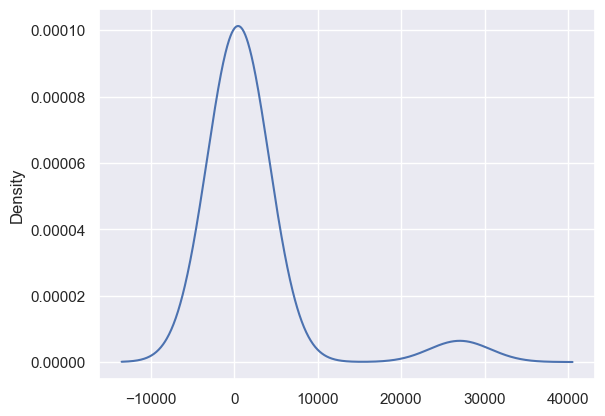

In [9]:
# Visualize the value counts of APPLICATION_TYPE
application_counts.plot.density()

### STEP 5A - Set Cutoff Point for Binning at 500

In [10]:
list(application_counts[application_counts < 500].index)

['T9', 'T13', 'T12', 'T2', 'T25', 'T14', 'T29', 'T15', 'T17']

In [11]:
# Determine which values to replace if counts are less than ...?
replace_application = list(application_counts[application_counts < 500].index)

# Replace in dataframe
for app in replace_application:
    application_df.APPLICATION_TYPE = application_df.APPLICATION_TYPE.replace(app,"Other")
    
# Check to make sure binning was successful
application_df.APPLICATION_TYPE.value_counts()

T3       27037
T4        1542
T6        1216
T5        1173
T19       1065
T8         737
T7         725
T10        528
Other      276
Name: APPLICATION_TYPE, dtype: int64

### STEP 5B - Create Density Plot for CLASSIFICATION

In [12]:
# Look at CLASSIFICATION value counts for binning
class_counts = application_df["CLASSIFICATION"].value_counts()
class_counts

C1000    17326
C2000     6074
C1200     4837
C3000     1918
C2100     1883
         ...  
C4120        1
C8210        1
C2561        1
C4500        1
C2150        1
Name: CLASSIFICATION, Length: 71, dtype: int64

<AxesSubplot:ylabel='Density'>

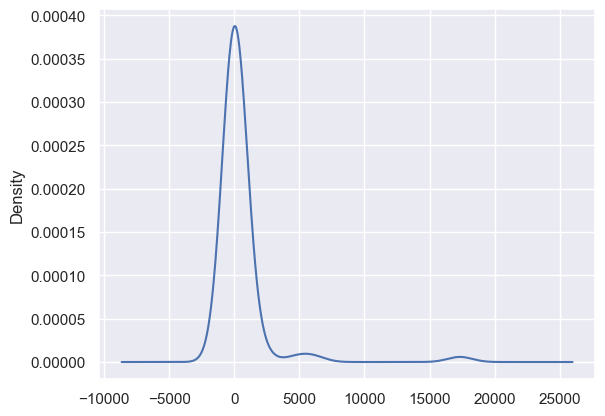

In [13]:
# Visualize the value counts of CLASSIFICATION
class_counts.plot.density()

### STEP 6B - Set Cutoff Point for Binning at 1000

In [14]:
list(class_counts[class_counts < 1000].index)

['C7000',
 'C1700',
 'C4000',
 'C5000',
 'C1270',
 'C2700',
 'C2800',
 'C7100',
 'C1300',
 'C1280',
 'C1230',
 'C1400',
 'C7200',
 'C2300',
 'C1240',
 'C8000',
 'C7120',
 'C1500',
 'C1800',
 'C6000',
 'C1250',
 'C8200',
 'C1238',
 'C1278',
 'C1235',
 'C1237',
 'C7210',
 'C2400',
 'C1720',
 'C4100',
 'C1257',
 'C1600',
 'C1260',
 'C2710',
 'C0',
 'C3200',
 'C1234',
 'C1246',
 'C1267',
 'C1256',
 'C2190',
 'C4200',
 'C2600',
 'C5200',
 'C1370',
 'C1248',
 'C6100',
 'C1820',
 'C1900',
 'C1236',
 'C3700',
 'C2570',
 'C1580',
 'C1245',
 'C2500',
 'C1570',
 'C1283',
 'C2380',
 'C1732',
 'C1728',
 'C2170',
 'C4120',
 'C8210',
 'C2561',
 'C4500',
 'C2150']

In [15]:
# Determine which values to replace if counts are less than ..?
replace_class = list(class_counts[class_counts < 1000].index)

# Replace in dataframe
for cls in replace_class:
    application_df.CLASSIFICATION = application_df.CLASSIFICATION.replace(cls,"Other")
    
# Check to make sure binning was successful
application_df.CLASSIFICATION.value_counts()

C1000    17326
C2000     6074
C1200     4837
Other     2261
C3000     1918
C2100     1883
Name: CLASSIFICATION, dtype: int64

In [16]:
application_df.nunique()

NAME                19568
APPLICATION_TYPE        9
AFFILIATION             6
CLASSIFICATION          6
USE_CASE                5
ORGANIZATION            4
INCOME_AMT              9
ASK_AMT              8747
IS_SUCCESSFUL           2
dtype: int64

### STEP 5B - OPTIMIZATION - Create Density Plot for NAME

In [17]:
#Bin NAMES
name_counts = application_df["NAME"].value_counts()
name_counts

PARENT BOOSTER USA INC                                                  1260
TOPS CLUB INC                                                            765
UNITED STATES BOWLING CONGRESS INC                                       700
WASHINGTON STATE UNIVERSITY                                              492
AMATEUR ATHLETIC UNION OF THE UNITED STATES INC                          408
                                                                        ... 
ST LOUIS SLAM WOMENS FOOTBALL                                              1
AIESEC ALUMNI IBEROAMERICA CORP                                            1
WEALLBLEEDRED ORG INC                                                      1
AMERICAN SOCIETY FOR STANDARDS IN MEDIUMSHIP & PSYCHICAL INVESTIGATI       1
WATERHOUSE CHARITABLE TR                                                   1
Name: NAME, Length: 19568, dtype: int64

<AxesSubplot:ylabel='Density'>

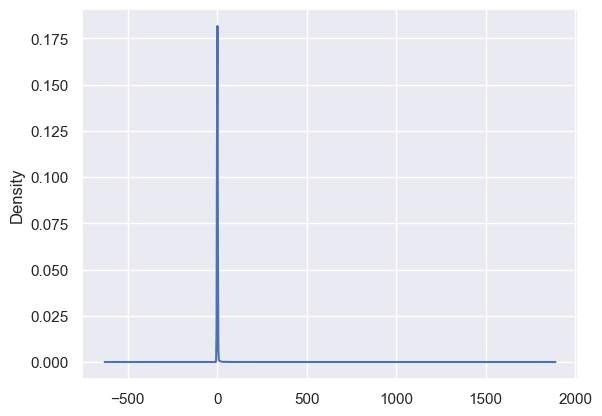

In [18]:
# Visualize the value counts of NAME
name_counts.plot.density()

### STEP 6B - Set Cutoff Points for Binning at 5

In [19]:
name_counts[name_counts <= 5]

FLORIDA FAMILY CHILD CARE HOME ASSOCIATION INC                          5
GERONTOLOGICAL ADVANCED PRACTICE NURSES ASSOCIATION                     5
INTERNATIONL TRANSPLANT NURSES SOCIETY                                  5
NATIONAL ORGANIZATION FOR WOMEN INC                                     5
PTA HAWAII CONGRESS                                                     5
                                                                       ..
ST LOUIS SLAM WOMENS FOOTBALL                                           1
AIESEC ALUMNI IBEROAMERICA CORP                                         1
WEALLBLEEDRED ORG INC                                                   1
AMERICAN SOCIETY FOR STANDARDS IN MEDIUMSHIP & PSYCHICAL INVESTIGATI    1
WATERHOUSE CHARITABLE TR                                                1
Name: NAME, Length: 19214, dtype: int64

In [20]:
# Use bucket technique to put those with 5 or less into a bucket 
# Determine which values to replace if counts are less than ..?
replace_name = list(name_counts[name_counts <= 5].index)

# Replace in dataframe
for name in replace_name:
    application_df["NAME"] = application_df["NAME"].replace(name,"Other")
    
# Check to make sure binning was successful
application_df["NAME"].value_counts()

Other                                           20043
PARENT BOOSTER USA INC                           1260
TOPS CLUB INC                                     765
UNITED STATES BOWLING CONGRESS INC                700
WASHINGTON STATE UNIVERSITY                       492
                                                ...  
HABITAT FOR HUMANITY INTERNATIONAL                  6
DAMAGE PREVENTION COUNCIL OF TEXAS                  6
FLEET RESERVE ASSOCIATION                           6
HUGH OBRIAN YOUTH LEADERSHIP                        6
INTERNATIONAL CONGRESS OF CHURCHES MINISTERS        6
Name: NAME, Length: 355, dtype: int64

In [21]:
application_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34299 entries, 0 to 34298
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   NAME              34299 non-null  object
 1   APPLICATION_TYPE  34299 non-null  object
 2   AFFILIATION       34299 non-null  object
 3   CLASSIFICATION    34299 non-null  object
 4   USE_CASE          34299 non-null  object
 5   ORGANIZATION      34299 non-null  object
 6   INCOME_AMT        34299 non-null  object
 7   ASK_AMT           34299 non-null  int64 
 8   IS_SUCCESSFUL     34299 non-null  int64 
dtypes: int64(2), object(7)
memory usage: 2.4+ MB


### STEP 7 - List Categorical Variables

In [22]:
# Generate our categorical variable lists (See Module 19.4.2)
application_cat = application_df.dtypes[application_df.dtypes == "object"].index.tolist()
application_cat

['NAME',
 'APPLICATION_TYPE',
 'AFFILIATION',
 'CLASSIFICATION',
 'USE_CASE',
 'ORGANIZATION',
 'INCOME_AMT']

In [23]:
# Testing
application_df[application_cat]

,NAME,APPLICATION_TYPE,AFFILIATION,CLASSIFICATION,USE_CASE,ORGANIZATION,INCOME_AMT
0,BLUE KNIGHTS MOTORCYCLE CLUB,T10,Independent,C1000,ProductDev,Association,0
1,Other,T3,Independent,C2000,Preservation,Co-operative,1-9999
2,Other,T5,CompanySponsored,C3000,ProductDev,Association,0
3,Other,T3,CompanySponsored,C2000,Preservation,Trust,10000-24999
4,Other,T3,Independent,C1000,Heathcare,Trust,100000-499999
...,...,...,...,...,...,...,...
34294,Other,T4,Independent,C1000,ProductDev,Association,0
34295,INTERNATIONAL ASSOCIATION OF LIONS CLUBS,T4,CompanySponsored,C3000,ProductDev,Association,0
34296,Other,T3,CompanySponsored,C2000,Preservation,Association,0
34297,Other,T5,Independent,C3000,ProductDev,Association,0


In [24]:
# Create a OneHotEncoder instance
enc = OneHotEncoder(sparse=False)

# Fit and transform the OneHotEncoder using the categorical variable list
encode_df = pd.DataFrame(enc.fit_transform(application_df[application_cat]))

# Add the encoded variable names to the dataframe
encode_df.columns = enc.get_feature_names_out(application_cat)
encode_df.head()

,NAME_AACE INTERNATIONAL,NAME_ACE MENTOR PROGRAM OF AMERICA INC,NAME_AFRICAN-AMERICAN POSTAL LEAGUE UNITED FOR SUCCESS A-PLUS,NAME_AIR FORCE ASSOCIATION,NAME_ALABAMA FEDERATION OF WOMENS CLUBS,NAME_ALABAMA TREASURE FOREST ASSOCIATION,NAME_ALBANY STATE UNIVERSITY NATIONAL ALUMNI ASSOCIATION,NAME_ALPHA PHI OMEGA,NAME_ALPHA PHI SIGMA,NAME_ALPHA PHI SIGMA INC,...,ORGANIZATION_Trust,INCOME_AMT_0,INCOME_AMT_1-9999,INCOME_AMT_10000-24999,INCOME_AMT_100000-499999,INCOME_AMT_10M-50M,INCOME_AMT_1M-5M,INCOME_AMT_25000-99999,INCOME_AMT_50M+,INCOME_AMT_5M-10M
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


### STEP 9 - MERGE Newly Encoded Columns and Drop Previous Columns

In [25]:
# Merge one-hot encoded features and drop the originals
application_df = application_df.merge(encode_df, left_index=True, right_index=True)
application_df = application_df.drop(application_cat, 1)
application_df.head()

C:\Users\alice.hayden\AppData\Local\Temp\ipykernel_19496\3768494989.py:3: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  application_df = application_df.drop(application_cat, 1)


,ASK_AMT,IS_SUCCESSFUL,NAME_AACE INTERNATIONAL,NAME_ACE MENTOR PROGRAM OF AMERICA INC,NAME_AFRICAN-AMERICAN POSTAL LEAGUE UNITED FOR SUCCESS A-PLUS,NAME_AIR FORCE ASSOCIATION,NAME_ALABAMA FEDERATION OF WOMENS CLUBS,NAME_ALABAMA TREASURE FOREST ASSOCIATION,NAME_ALBANY STATE UNIVERSITY NATIONAL ALUMNI ASSOCIATION,NAME_ALPHA PHI OMEGA,...,ORGANIZATION_Trust,INCOME_AMT_0,INCOME_AMT_1-9999,INCOME_AMT_10000-24999,INCOME_AMT_100000-499999,INCOME_AMT_10M-50M,INCOME_AMT_1M-5M,INCOME_AMT_25000-99999,INCOME_AMT_50M+,INCOME_AMT_5M-10M
0,5000,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,108590,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,5000,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,6692,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
4,142590,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


In [26]:
application_df.shape

(34299, 396)

In [27]:
# Check to see if all columns are numeric
application_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34299 entries, 0 to 34298
Columns: 396 entries, ASK_AMT to INCOME_AMT_5M-10M
dtypes: float64(394), int64(2)
memory usage: 103.6 MB


### STEP 10 - Split Preprocessed Data into Features and Target Arrays

In [28]:
# Split our preprocessed data into our features and target arrays
# X is our feature matrix, so we need to drop the target out of our feature matrix
X_df = application_df.drop(["IS_SUCCESSFUL"], 1)

X = X_df.values

# Let's get our target column values
y = application_df["IS_SUCCESSFUL"].values

C:\Users\alice.hayden\AppData\Local\Temp\ipykernel_19496\4152216851.py:3: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  X_df = application_df.drop(["IS_SUCCESSFUL"], 1)


### STEP 11 - Create Training and Testing Data

In [29]:
# Split the preprocessed data into a training and testing dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 78)

### STEP 12 - Scale the Data

In [30]:
# Create a StandardScaler instances
scaler = StandardScaler()

# Fit the StandardScaler
X_scaler = scaler.fit(X_train)

# Scale the data
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

### Deliverable 2: Compile, Train and Evaluate the Model

In [31]:
# testing
len(X_train_scaled[0])

395

### STEPS 2 thru 6 - Create a Neural Network Model Using Tensorflow Keras

### OPTIMIZATION 2: Remove 4th Layer, Change Activation

In [32]:
# Define the model - deep neural net, i.e., the number of input features and hidden nodes for each layer.
number_input_features = len(X_train_scaled[0])

# Module 19.2.5 Rule of Thumb for a Basic Neural Network
# Have two to three times the amount of neurons in the hidden layer
# as the number of inputs
hidden_nodes_layer1 = number_input_features * 3
hidden_nodes_layer2 = number_input_features * 2
hidden_nodes_layer3 = number_input_features * 1

nn = tf.keras.models.Sequential()
nn._name = "D3_Optimization_4_Model"

# First hidden layer
# "relu" is a default activation method, it's a good general purpose one to use
nn.add(tf.keras.layers.Dense(units=hidden_nodes_layer1, input_dim=number_input_features, activation="relu", name="1st_Layer_RELU"))

# Second hidden layer
nn.add(tf.keras.layers.Dense(units=hidden_nodes_layer2, activation="relu", name="2nd_Layer_RELU"))

# Third hidden layer
nn.add(tf.keras.layers.Dense(units=hidden_nodes_layer3, activation="relu", name="3rd_Layer_RELU"))

# Output layer
nn.add(tf.keras.layers.Dense(units=1, activation="sigmoid", name="Outer_Layer_SIGMOID"))
       
# Check the structure of the model
nn.summary()

Model: "D3_Optimization_4_Model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 1st_Layer_RELU (Dense)      (None, 1185)              469260    
                                                                 
 2nd_Layer_RELU (Dense)      (None, 790)               936940    
                                                                 
 3rd_Layer_RELU (Dense)      (None, 395)               312445    
                                                                 
 Outer_Layer_SIGMOID (Dense)  (None, 1)                396       
                                                                 
Total params: 1,719,041
Trainable params: 1,719,041
Non-trainable params: 0
_________________________________________________________________


### STEP 7 - Compile the Model

In [33]:
# Compile the model
# We choose "binary_corssentropy" because we are making a binary choice and
# entropy is what we are trying to reduce, the amount of variability in the problem
# Model will start from a random place 1) first it will measure it's accuracy
# 2) Make a change from where it's currently at by changing the weighting using the "adam" optimizer
# 3) then try to minimize its loss function using "binary_crossentropy"
# It will continually arrive at a new point and bounce through with these 3 things
nn.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

### STEP 8 - Implement Checkpoints
Note: Create a callback that saves the model's weights every 5 epochs

In [34]:
# Create a callback that saves the model's weights every epoch
cp_callback = ModelCheckpoint(
    filepath=checkpoint_path,
    verbose=1,
    save_weights_only=True,
    save_freq=5)

### STEP 7 - Train the Model

In [35]:
# Train the model
fit_model = nn.fit(X_train_scaled, y_train, epochs=100)

Epoch 1/100
804/804 [==============================] - 10s 11ms/step - loss: 0.4714 - accuracy: 0.7793
Epoch 2/100
804/804 [==============================] - 10s 12ms/step - loss: 0.4362 - accuracy: 0.7932
Epoch 3/100
804/804 [==============================] - 9s 11ms/step - loss: 0.4308 - accuracy: 0.7951
Epoch 4/100
804/804 [==============================] - 9s 11ms/step - loss: 0.4288 - accuracy: 0.7957
Epoch 5/100
804/804 [==============================] - 9s 12ms/step - loss: 0.4272 - accuracy: 0.7975
Epoch 6/100
804/804 [==============================] - 9s 12ms/step - loss: 0.4273 - accuracy: 0.7964
Epoch 7/100
804/804 [==============================] - 10s 12ms/step - loss: 0.4258 - accuracy: 0.7966
Epoch 8/100
804/804 [==============================] - 10s 12ms/step - loss: 0.4246 - accuracy: 0.7969
Epoch 9/100
804/804 [==============================] - 10s 12ms/step - loss: 0.4240 - accuracy: 0.7986
Epoch 10/100
804/804 [==============================] - 9s 11ms/step - loss: 

In [36]:
# Evaluate the model using the test data
print("D3 Optimization 4 Model")
model_loss, model_accuracy = nn.evaluate(X_test_scaled,y_test,verbose=2)
print(f"Loss: {model_loss}, Accuracy: {model_accuracy}")

D3 Optimization 4 Model
268/268 - 1s - loss: 0.6402 - accuracy: 0.7869 - 1s/epoch - 4ms/step
Loss: 0.6401916146278381, Accuracy: 0.7869387865066528


### STEP 9 - Save and Export the Model

In [37]:
# Export the model to HDF5 file
nn.save("Trained_Models/AlphabetSoupCharity_Optimization_D3_4.h5")

In [38]:
# Import the model to a new object
nn_imported = tf.keras.models.load_model("Trained_Models/AlphabetSoupCharity_Optimization_D3_4.h5")

In [39]:
# Evaluate the completed model using the test data
model_loss, model_accuracy = nn_imported.evaluate(X_test_scaled,y_test,verbose=2)
print(f"Loss: {model_loss}, Accuracy: {model_accuracy}")

268/268 - 1s - loss: 0.6402 - accuracy: 0.7869 - 967ms/epoch - 4ms/step
Loss: 0.6401916146278381, Accuracy: 0.7869387865066528


### STEP 9 - Further Evaluations of the Model

<AxesSubplot:title={'center':'D3 - Optimization 4 Model Loss Chart'}>

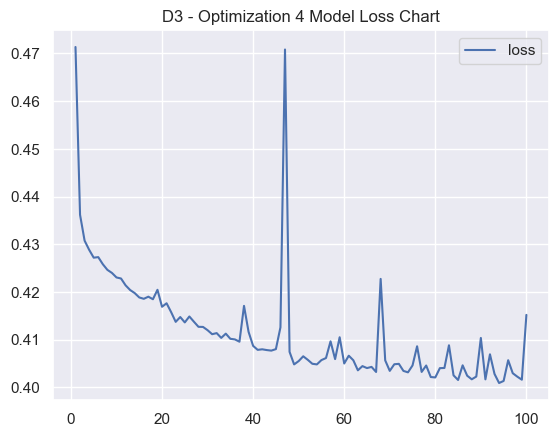

In [40]:
# Create a DataFrame containing training history
history_df = pd.DataFrame(fit_model.history, index=range(1, len(fit_model.history["loss"])+1))

# Plot the loss
history_df.plot(y="loss", title="D3 - Optimization 4 Model Loss Chart")

<AxesSubplot:title={'center':'D3 - Optimization 4 Model Accuracy Chart'}>

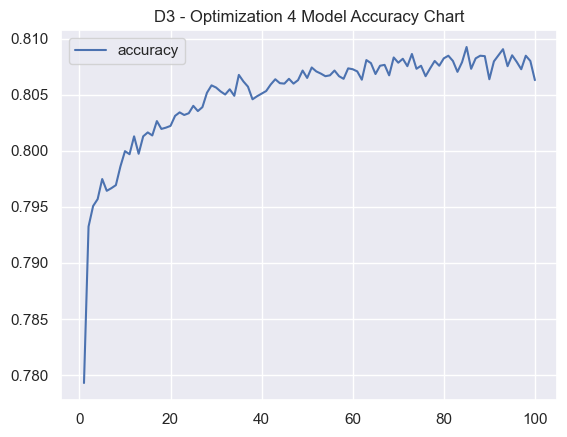

In [41]:
# Plot the accuracy
history_df.plot(y="accuracy", title="D3 - Optimization 4 Model Accuracy Chart")

In [42]:
# Evaluate the model using the test data
print("D3 Optimization 4 Model")
model_loss, model_accuracy = nn.evaluate(X_test_scaled,y_test,verbose=2)
print(f"Loss: {model_loss}, Accuracy: {model_accuracy}")

D3 Optimization 4 Model
268/268 - 1s - loss: 0.6402 - accuracy: 0.7869 - 934ms/epoch - 3ms/step
Loss: 0.6401916146278381, Accuracy: 0.7869387865066528


## Random Forest Classifer

In [43]:
# Instantiate a random forest classifier variable
rf_model = RandomForestClassifier(n_estimators=200, random_state=1)

# Fit the model
rf_model = rf_model.fit(X_train_scaled, y_train)

# Evaluate the model
y_pred = rf_model.predict(X_test_scaled)
print(f"Random forest predictive accuracy is {accuracy_score(y_test, y_pred):.3f}")

Random forest predictive accuracy is 0.776


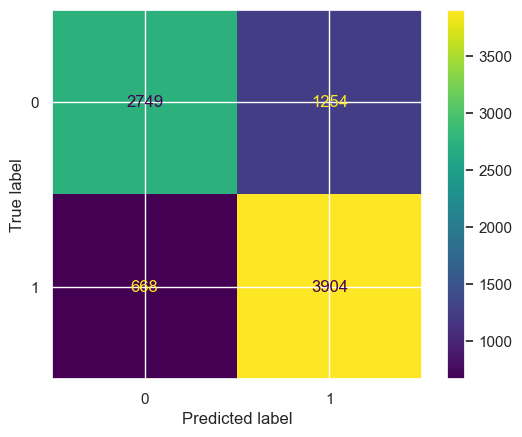

In [49]:
# Display the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Display the confusion matrix display
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=rf_model.classes_)
disp.plot()
plt.show()

In [45]:
# Classification report
report = classification_report(y_test, y_pred)
print(report)

              precision    recall  f1-score   support

           0       0.80      0.69      0.74      4003
           1       0.76      0.85      0.80      4572

    accuracy                           0.78      8575
   macro avg       0.78      0.77      0.77      8575
weighted avg       0.78      0.78      0.77      8575



In [46]:
importances = rf_model.feature_importances_

# get column names
columns = X_df.columns

#create a dataframe
feature_importances_df = pd.DataFrame({"feature": columns, "importances": importances})

feature_importances_df.sort_values(by=["importances"], ascending=False, inplace=True)
feature_importances_df.reset_index(drop=True, inplace=True)
feature_importances_df

,feature,importances
0,ASK_AMT,0.274360
1,NAME_Other,0.072332
2,AFFILIATION_Independent,0.059615
3,AFFILIATION_CompanySponsored,0.055770
4,ORGANIZATION_Association,0.019687
...,...,...
390,NAME_DEPARTMENT OF UTAH LADIES AUXILIARY TO TH...,0.000018
391,NAME_VFW AUXILIARY DEPT OF HAWAII,0.000016
392,NAME_DAUGHTERS OF CHARITY HEALTH SYSTEM,0.000012
393,NAME_VETERANS OF FOREIGN WARS DEPARTMENT OF KA...,0.000009


C:\Users\alice.hayden\AppData\Local\Temp\ipykernel_19496\3417574529.py:10: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  fig.tight_layout()


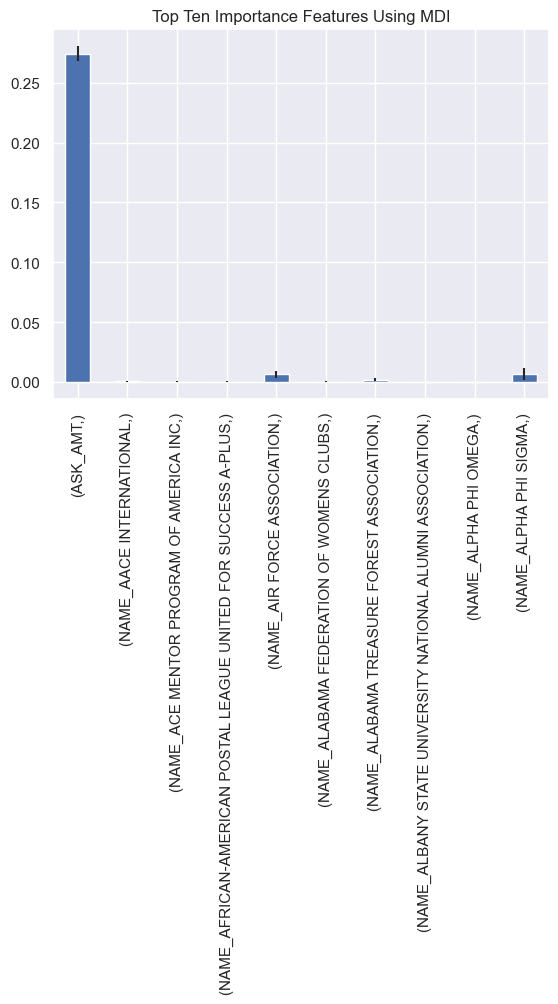

In [47]:
# get the top ten
importances = rf_model.feature_importances_[: 10]
std = np.std([tree.feature_importances_[:10] for tree in rf_model.estimators_], axis=0)

forest_importances = pd.Series(importances, index=[X_df.columns[: 10]])

fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Top Ten Importance Features Using MDI")
fig.tight_layout()